In [14]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
import geopandas as gpd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
# import matplotlib.colors as colors
import matplotlib.colors as mcolors

pd.set_eng_float_format(accuracy=4, use_eng_prefix=True)

import sys
sys.path.append('..')
from src.utils import get_data
from src.clustering import STPClustering, mst_prims_algorithm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
terminals, time_matrix = get_data('../data/')

idx = np.random.choice(len(terminals), size=int(0.1 * len(time_matrix)), replace=False)
terminals = terminals.iloc[idx]
time_matrix = time_matrix[np.ix_(idx, idx)]
clusters = STPClustering(max_length=540).fit_predict(time_matrix)
len(clusters)

8

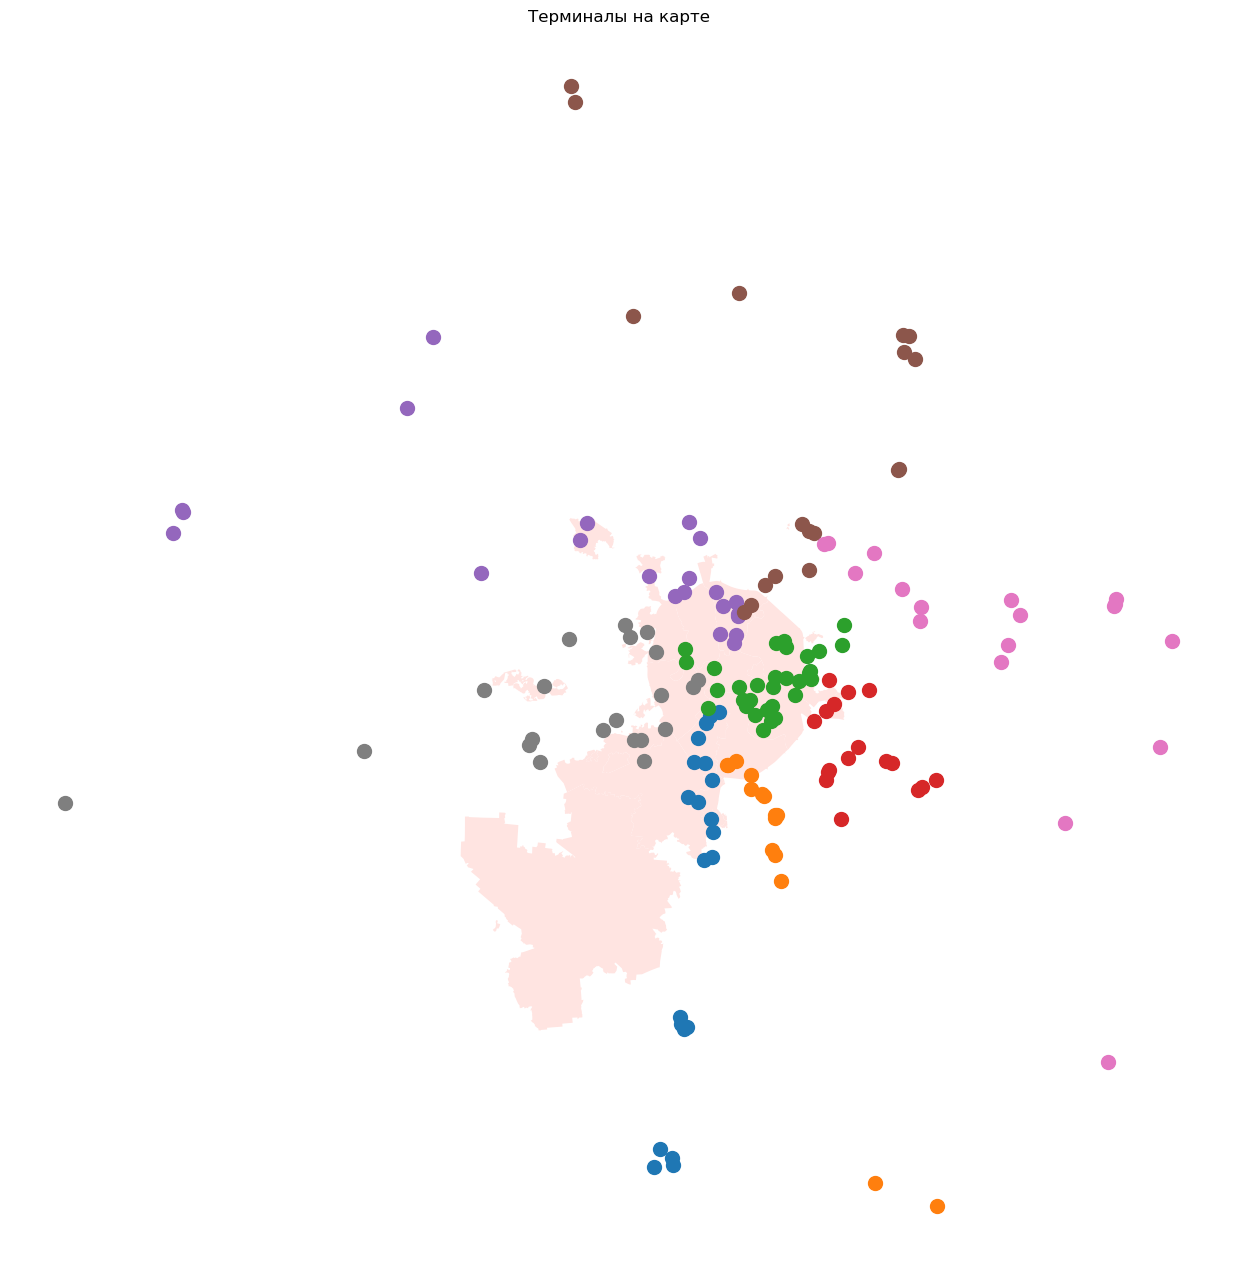

In [24]:
colors = list(mcolors.TABLEAU_COLORS)#list(mcolors.CSS4_COLORS)
moscow = gpd.read_file('ao-shape.zip')

fig, ax = plt.subplots(figsize=(16, 16))
moscow.plot(ax=ax, color='mistyrose')

for cluster, color in zip(clusters, colors):
    ax.scatter(terminals['longitude'].iloc[cluster], terminals['latitude'].iloc[cluster], s=100, c=color)

plt.axis('off')
plt.title('Терминалы на карте')
plt.show()

In [34]:
def dfs(i, visited, tree, path):
    visited[i] = True
    path.append(i)
    for j in tree[i]:
        if not visited[j]:
            dfs(j, visited, tree, path)


paths = []
times = []
for cluster in clusters:
    subset = time_matrix[np.ix_(cluster, cluster)]
    tree = mst_prims_algorithm(subset)

    path = []
    visited = [False] * len(subset)
    dfs(0, visited, tree, path)
    path = cluster[path]
    assert len(np.unique(path)) == len(path)

    src, dst = path[:-1], path[1:]
    elapsed = (time_matrix[src, dst]).sum() + 10 * len(path)

    paths.append(cluster)
    times.append(elapsed)

times = np.array(times)
np.round([times.min(), times.max(), times.mean()], 3)

array([368.84 , 675.6  , 527.291])

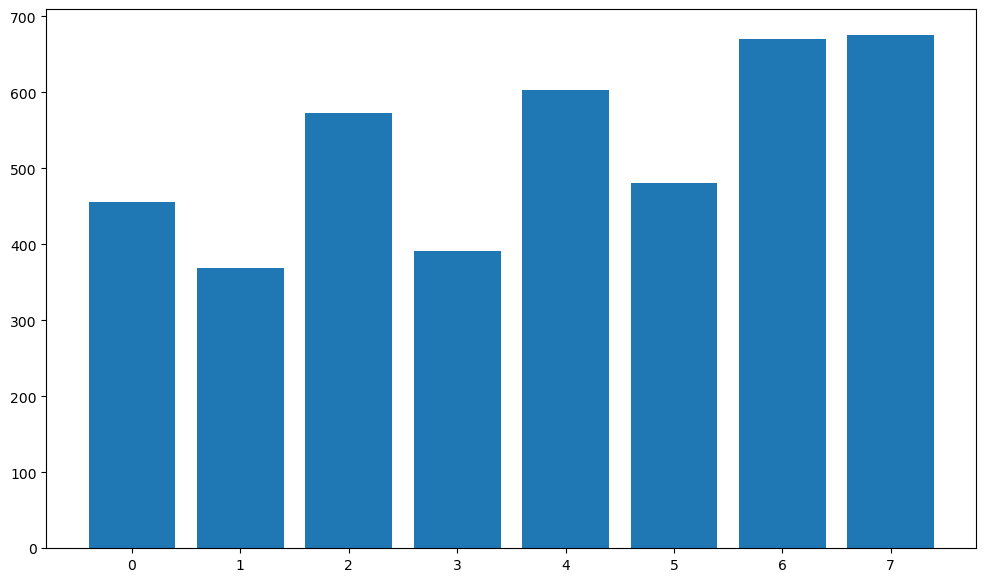

In [27]:
plt.figure(figsize=(12, 7))
plt.bar(np.arange(len(times)), times)
plt.show()

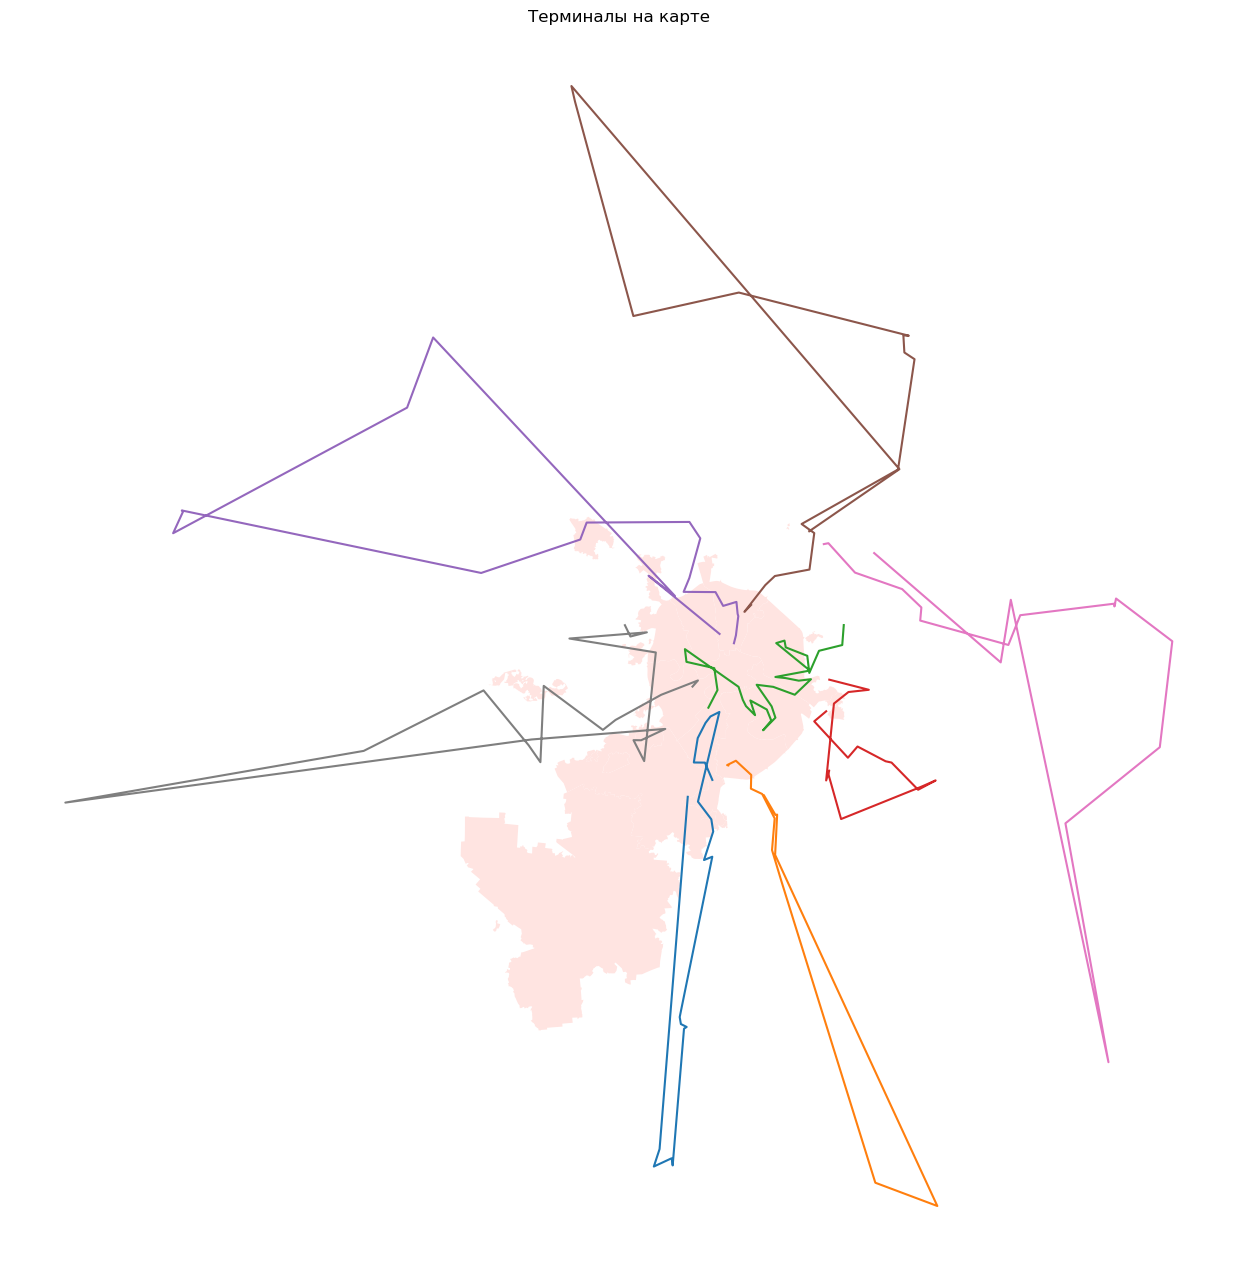

In [29]:
# import matplotlib.colors as mcolors


# colors = list(mcolors.CSS4_COLORS)
moscow = gpd.read_file('ao-shape.zip')

fig, ax = plt.subplots(figsize=(16, 16))
moscow.plot(ax=ax, color='mistyrose')

for path, color in zip(paths, colors):
    ax.plot(terminals['longitude'].iloc[path], terminals['latitude'].iloc[path], c=color)

plt.axis('off')
plt.title('Терминалы на карте')
plt.show()

In [79]:
import networkx as nx
tsp = nx.approximation.traveling_salesman_problem


def tsp_solution(distances):
    sym_distances = np.maximum(np.tril(distances), np.triu(distances).T)
    sym_distances = sym_distances + sym_distances.T
    G = nx.from_numpy_array(sym_distances)

    if sym_distances.shape[0] > 1:
        path = tsp(G, cycle=False)
    else:
        path = [0]
        
    return path


paths = []
times = []
for cluster in clusters:

    subset = time_matrix[np.ix_(cluster, cluster)]
    # for i in range(len(subset)):
    #     for j in range(len(subset)):
    #         subset[i, j] = min(subset[i, j], np.min(subset[i, :] + subset[:, j]))
    
    path = tsp_solution(subset)
    src, dst = path[:-1], path[1:]
    elapsed = (subset[src, dst]).sum() + 10 * len(path)
    # assert len(np.unique(path)) == len(path)

    paths.append(cluster[path])
    times.append(elapsed)

times = np.array(times)
times.max()

616.72

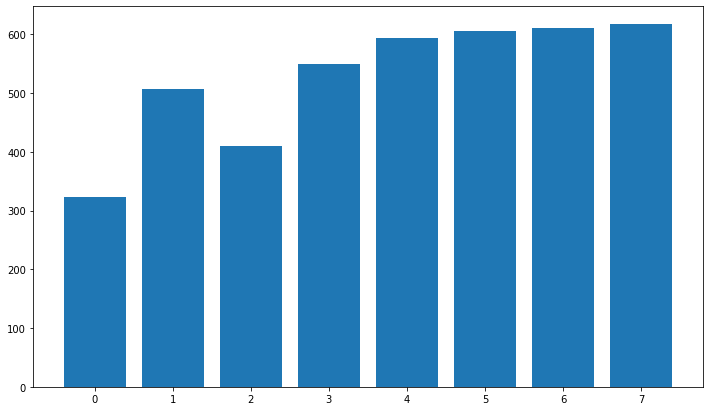

In [80]:
plt.figure(figsize=(12, 7))
plt.bar(np.arange(len(times)), times)
plt.show()

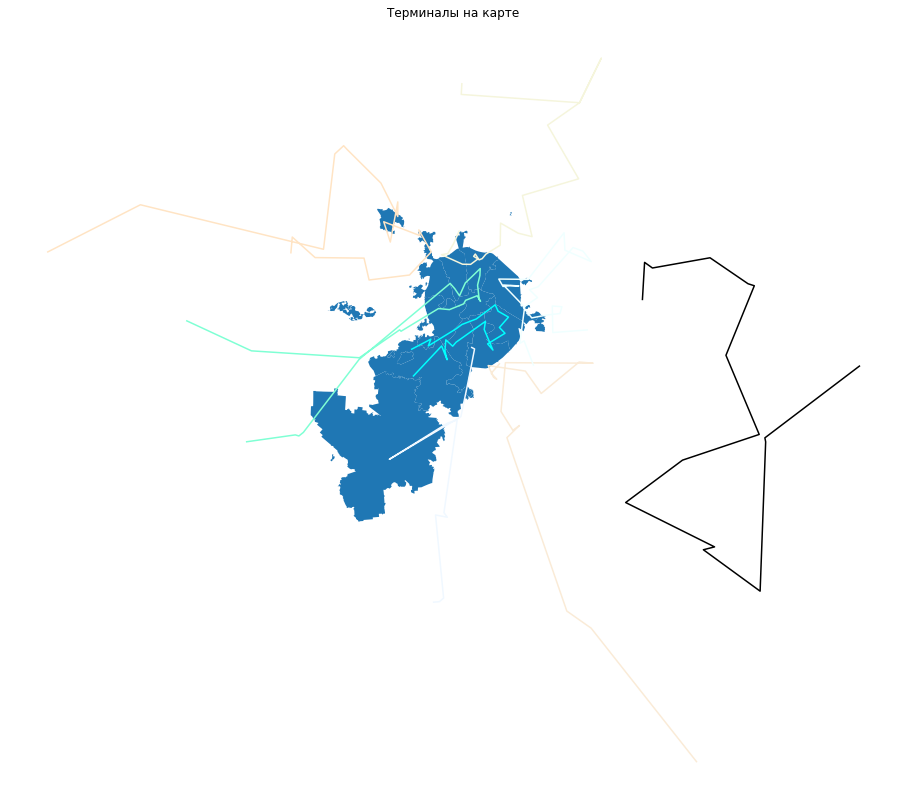

In [81]:
import matplotlib.colors as mcolors


colors = list(mcolors.CSS4_COLORS)
moscow = gpd.read_file('ao-shape.zip')

fig, ax = plt.subplots(figsize=(16, 16))
moscow.plot(ax=ax)

for path, color in zip(paths, colors):
    ax.plot(terminals['longitude'].iloc[path], terminals['latitude'].iloc[path], c=color)

plt.axis('off')
plt.title('Терминалы на карте')
plt.show()